# Using quadratic approximation and MCMC for the proportion of water on the Earth's surface

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, multivariate_normal, binom

import pymc as pm
import arviz as az

In [2]:
n = 9
x = 6

In [3]:
with pm.Model() as ModelWater:
    theta = pm.Uniform('theta', 0, 1)
    water = pm.Binomial('water', n=n, p=theta, observed=x)
    MeanQ = pm.find_MAP()

with pm.Model() as ModelWater2:
    theta = pm.Uniform('theta', 0, 1, transform=None)
    water = pm.Binomial('water', n=n, p=theta, observed=x, transform=None)

    IFisher = pm.find_hessian(MeanQ, vars=[theta])
    StdQ = (1/IFisher**0.5)[0]

(array(0.66666667), array([0.15713484]))

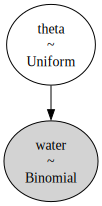

In [4]:
pm.model_to_graphviz(ModelWater)

## Using the normal approximation

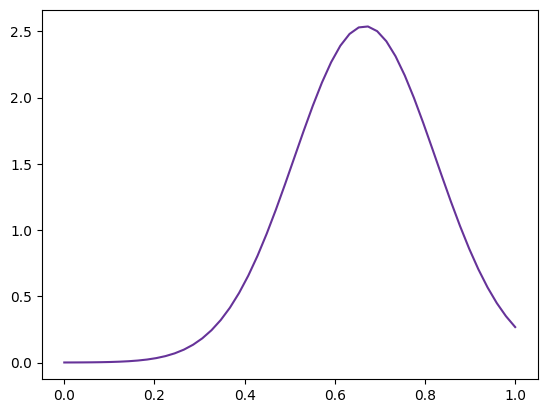

In [5]:
ThetaGrid = np.linspace(0,1)
PosteriorQuadraticApprox = norm.pdf(ThetaGrid, MeanQ['theta'], StdQ)
plt.plot(ThetaGrid, PosteriorQuadraticApprox, color='rebeccapurple')

Sample from the approximate normal posterior.

In [6]:
NPosterior = 10**4
PosteriorSample = norm.rvs(size=NPosterior, loc=MeanQ['theta'], scale=StdQ)
PosteriorSample = PosteriorSample[(PosteriorSample<1) & (PosteriorSample>0)]

Posterior interval of 0.5 of probability.

In [7]:
np.quantile(PosteriorSample, [0.25, 0.75])

array([0.55887896, 0.76197537])

Sample from the posterior predictive.

In [8]:
WaterPosterior = binom.rvs(size=len(PosteriorSample), n=n, p=PosteriorSample)
WaterPosterior

array([5, 5, 4, ..., 8, 9, 9])

Posterior predictive interval of 0.5 of probability.

In [9]:
np.quantile(WaterPosterior, [0.25, 0.75])

array([5., 7.])

## Using MCMC

In [10]:
with ModelWater:
    TraceWater = pm.sample()
    TraceWater.extend(pm.sample_posterior_predictive(TraceWater))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [water]


Posterior interval of 0.5 of probability.

In [11]:
az.summary(TraceWater, hdi_prob=0.5, kind='stats')

,mean,sd,hdi_25%,hdi_75%
theta,0.635,0.139,0.568,0.761


Posterior predictive interval of 0.5 of probability.

In [13]:
az.summary(TraceWater, group='posterior_predictive', hdi_prob=0.5, kind='stats')

,mean,sd,hdi_25%,hdi_75%
water,5.716,1.834,4.0,6.0
